In [11]:
import gc
import cv2
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import *
from tqdm import tqdm

print('TensorFlow version: %s' % tf.__version__)

TensorFlow version: 2.3.0


In [12]:
ROOT = '/Users/lixinyu/Desktop/kaggle_bee_vs_wasp/'
SEED = 42
EPOCHS = 10
BATCH_SIZE = 32
IMG_SIZE = 256


df = pd.read_csv(ROOT+'labels.csv')
df.head()

,id,path,is_bee,is_wasp,is_otherinsect,is_other,photo_quality,is_validation,is_final_validation,label
0,1,bee1\10007154554_026417cfd0_n.jpg,1,0,0,0,1,0,0,bee
1,2,bee1\10024864894_6dc54d4b34_n.jpg,1,0,0,0,1,0,1,bee
2,3,bee1\10092043833_7306dfd1f0_n.jpg,1,0,0,0,1,1,0,bee
3,4,bee1\1011948979_fc3637e779_w.jpg,1,0,0,0,1,0,1,bee
4,5,bee1\10128235063_dca17db76c_n.jpg,1,0,0,0,1,0,0,bee


In [13]:
import os
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

seed_everything(SEED)

In [14]:
for idx in tqdm(df.index):    
    df.loc[idx,'path']=df.loc[idx,'path'].replace('\\', '/') 
    
df.head()

100%|██████████| 11421/11421 [00:04<00:00, 2673.48it/s]


,id,path,is_bee,is_wasp,is_otherinsect,is_other,photo_quality,is_validation,is_final_validation,label
0,1,bee1/10007154554_026417cfd0_n.jpg,1,0,0,0,1,0,0,bee
1,2,bee1/10024864894_6dc54d4b34_n.jpg,1,0,0,0,1,0,1,bee
2,3,bee1/10092043833_7306dfd1f0_n.jpg,1,0,0,0,1,1,0,bee
3,4,bee1/1011948979_fc3637e779_w.jpg,1,0,0,0,1,0,1,bee
4,5,bee1/10128235063_dca17db76c_n.jpg,1,0,0,0,1,0,0,bee


In [15]:
df = df.query('photo_quality == 1')
df['label'].value_counts()

bee       2469
insect    2439
wasp      2127
Name: label, dtype: int64

In [145]:
df.shape[0]

7035

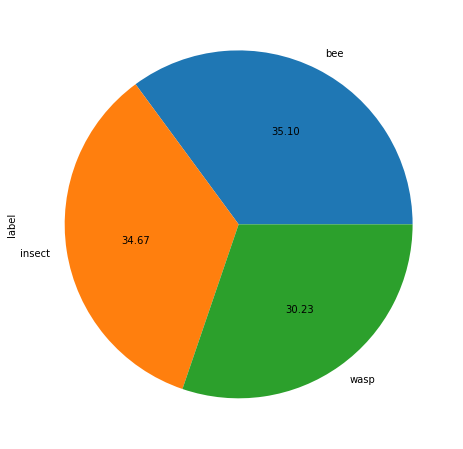

In [126]:
df['label'].value_counts().plot.pie(figsize=(8,8),autopct='%.2f')

In [16]:
train_df = df.query('is_validation == 0 & is_final_validation == 0').reset_index(drop=True)
val_df = df.query('is_validation == 1').reset_index(drop=True)
test_df = df.query('is_final_validation == 1').reset_index(drop=True)

In [17]:
def create_datasets(df, img_size):
    imgs = []
    for path in tqdm(df['path']):
        img = cv2.imread(ROOT+path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_size,img_size))
        imgs.append(img)
        
    imgs = np.array(imgs, dtype='float32')
    imgs = imgs / 255.0
    df = pd.get_dummies(df['label'])
    return imgs, df


train_imgs, train_df = create_datasets(train_df, IMG_SIZE)
val_imgs, val_df = create_datasets(val_df, IMG_SIZE)
test_imgs, test_df = create_datasets(test_df, IMG_SIZE)

100%|██████████| 1084/1084 [00:01<00:00, 558.73it/s]


In [65]:
def build_model(img_size, n):
    inp = Input(shape=(img_size,img_size,n))
    from tensorflow.keras.applications.resnet50 import ResNet50
    resnet = ResNet50(input_shape=(img_size,img_size,n), 
                                   weights='imagenet', 
                                   include_top=False)
    x = resnet(inp)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(3, activation='softmax')(x)
    model = tf.keras.Model(inputs=inp, outputs=x) 
    opt = tf.keras.optimizers.SGD(momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model(IMG_SIZE, 3)
model.summary()

Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_12  (None, 2048)              0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 3)                 6147      
Total params: 23,593,859
Trainable params: 23,540,739
Non-trainable params: 53,120
_________________________________________________________________


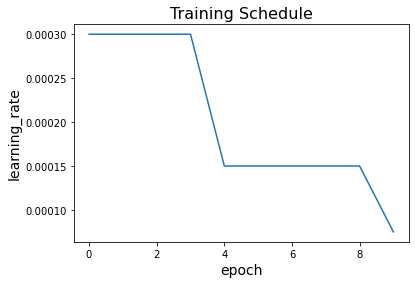

In [64]:
def get_lr_callback(batch_size=32, plot=False):
    start_lr = 3e-4
    def step_decay(epoch):
        drop = 0.5
        epochs_drop = 5.0
        lr = start_lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
        return lr
    
    lr_callback = tf.keras.callbacks.LearningRateScheduler(step_decay)
    if plot == True:
        rng = [i for i in range(EPOCHS)]
        y = [step_decay(x) for x in rng]
        plt.plot(rng, y)
        plt.xlabel('epoch', size=14)
        plt.ylabel('learning_rate', size=14)
        plt.title('Training Schedule', size=16)
        plt.show()
        
    return lr_callback


get_lr_callback(plot=True)

Epoch 1/10
154/154 [==============================] - 1111s 7s/step - loss: 0.3960 - accuracy: 0.8513 - val_loss: 1.4464 - val_accuracy: 0.3423
Epoch 2/10
154/154 [==============================] - 1142s 7s/step - loss: 0.2409 - accuracy: 0.9118 - val_loss: 1.6537 - val_accuracy: 0.3519
Epoch 3/10
154/154 [==============================] - 1120s 7s/step - loss: 0.1654 - accuracy: 0.9432 - val_loss: 1.5756 - val_accuracy: 0.3998
Epoch 4/10
154/154 [==============================] - 1117s 7s/step - loss: 0.1146 - accuracy: 0.9627 - val_loss: 1.1154 - val_accuracy: 0.5580
Epoch 5/10
154/154 [==============================] - 1376s 9s/step - loss: 0.0822 - accuracy: 0.9745 - val_loss: 0.7126 - val_accuracy: 0.7315
Epoch 6/10
154/154 [==============================] - 1154s 7s/step - loss: 0.0739 - accuracy: 0.9774 - val_loss: 0.3903 - val_accuracy: 0.8619
Epoch 7/10
154/154 [==============================] - 3845s 25s/step - loss: 0.0620 - accuracy: 0.9806 - val_loss: 0.2847 - val_accuracy

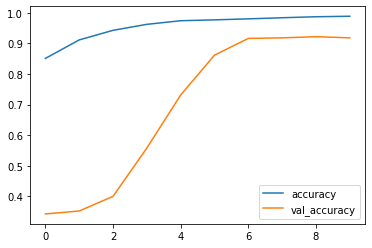

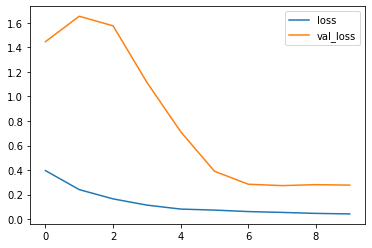

15889

In [22]:
es_callback = tf.keras.callbacks.EarlyStopping(patience=10, 
                                               verbose=1, 
                                               restore_best_weights=True)

history = model.fit(train_imgs, 
                    train_df, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=[es_callback, get_lr_callback(BATCH_SIZE)], 
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()

gc.collect()

In [23]:
model.evaluate(test_imgs, test_df) 

34/34 [==============================] - 53s 2s/step - loss: 0.2486 - accuracy: 0.9197


[0.2486221194267273, 0.919741690158844]

In [24]:
model.save('myResNet50.h5')

### random label

#### all-random

In [93]:
from random import shuffle
df_rand = df.copy()
test = np.array(df_rand['label'].tolist())
test = np.random.permutation(test)
test = np.array(test)
df_rand['label'] = test
df_rand.head()

,id,path,is_bee,is_wasp,is_otherinsect,is_other,photo_quality,is_validation,is_final_validation,label
0,1,bee1/10007154554_026417cfd0_n.jpg,1,0,0,0,1,0,0,bee
1,2,bee1/10024864894_6dc54d4b34_n.jpg,1,0,0,0,1,0,1,wasp
2,3,bee1/10092043833_7306dfd1f0_n.jpg,1,0,0,0,1,1,0,insect
3,4,bee1/1011948979_fc3637e779_w.jpg,1,0,0,0,1,0,1,insect
4,5,bee1/10128235063_dca17db76c_n.jpg,1,0,0,0,1,0,0,insect


In [94]:
df_rand = df_rand.query('photo_quality == 1')
df_rand['label'].value_counts()

bee       2469
insect    2439
wasp      2127
Name: label, dtype: int64

In [95]:
train_df_rand = df_rand.query('is_validation == 0 & is_final_validation == 0').reset_index(drop=True)
val_df_rand = df_rand.query('is_validation == 1').reset_index(drop=True)
test_df_rand = df_rand.query('is_final_validation == 1').reset_index(drop=True)

In [96]:
def create_datasets2(df, img_size):
    imgs = []
    for path in tqdm(df['path']):
        img = cv2.imread(ROOT+path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_size,img_size))
        imgs.append(img)
        
    imgs = np.array(imgs, dtype='float32')
    imgs = imgs / 255.0
    df = pd.get_dummies(df['label'])
    return imgs, df


train_imgs_rand, train_df_rand = create_datasets(train_df_rand, IMG_SIZE)
val_imgs_rand, val_df_rand = create_datasets(val_df_rand, IMG_SIZE)
test_imgs_rand, test_df_rand = create_datasets(test_df_rand, IMG_SIZE)

100%|██████████| 1084/1084 [00:01<00:00, 559.11it/s]


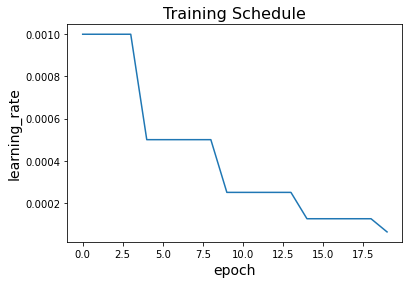

Epoch 1/20
154/154 [==============================] - 1144s 7s/step - loss: 1.3119 - accuracy: 0.3386 - val_loss: 1.4611 - val_accuracy: 0.3423
Epoch 2/20
154/154 [==============================] - 1131s 7s/step - loss: 1.0315 - accuracy: 0.4919 - val_loss: 1.2883 - val_accuracy: 0.3490
Epoch 3/20
154/154 [==============================] - 1149s 7s/step - loss: 0.7403 - accuracy: 0.6746 - val_loss: 1.2835 - val_accuracy: 0.3413
Epoch 4/20
154/154 [==============================] - 1143s 7s/step - loss: 0.4051 - accuracy: 0.8645 - val_loss: 1.6758 - val_accuracy: 0.3039
Epoch 5/20
154/154 [==============================] - 1133s 7s/step - loss: 0.1845 - accuracy: 0.9564 - val_loss: 2.1346 - val_accuracy: 0.2963
Epoch 6/20
154/154 [==============================] - 1114s 7s/step - loss: 0.0975 - accuracy: 0.9821 - val_loss: 2.1277 - val_accuracy: 0.3106
Epoch 7/20
154/154 [==============================] - 1113s 7s/step - loss: 0.0662 - accuracy: 0.9872 - val_loss: 2.0456 - val_accuracy:

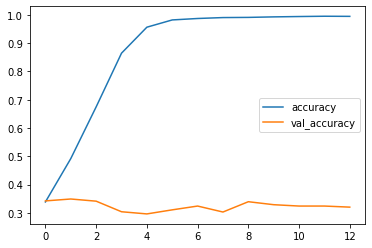

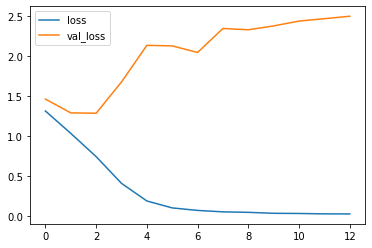

13830

In [100]:
EPOCHS2 = 20

def get_lr_callback(batch_size=32, plot=False):
    start_lr = 0.001
    def step_decay(epoch):
        drop = 0.5
        epochs_drop = 5.0
        lr = start_lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
        return lr
    
    lr_callback = tf.keras.callbacks.LearningRateScheduler(step_decay)
    if plot == True:
        rng = [i for i in range(EPOCHS2)]
        y = [step_decay(x) for x in rng]
        plt.plot(rng, y)
        plt.xlabel('epoch', size=14)
        plt.ylabel('learning_rate', size=14)
        plt.title('Training Schedule', size=16)
        plt.show()
        
    return lr_callback

get_lr_callback(plot=True)

es_callback = tf.keras.callbacks.EarlyStopping(patience=10, 
                                               verbose=1, 
                                               restore_best_weights=True)

history2 = model.fit(train_imgs_rand, 
                    train_df_rand, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS2, 
                    callbacks=[es_callback, get_lr_callback(BATCH_SIZE)], 
                    validation_data=(val_imgs_rand, val_df_rand))


pd.DataFrame(history2.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history2.history)[['loss', 'val_loss']].plot()
plt.show()

gc.collect()

#### half-random

In [103]:
df_rand_2 = df.copy()
train_df_rand_2 = df_rand_2.query('is_validation == 0 & is_final_validation == 0').reset_index(drop=True)
val_df_rand_2 = df_rand_2.query('is_validation == 1').reset_index(drop=True)
test_df_rand_2 = df_rand_2.query('is_final_validation == 1').reset_index(drop=True)

In [107]:
train_df_rand_2['label'].value_counts()

bee       1716
insect    1706
wasp      1486
Name: label, dtype: int64

In [109]:
l = np.random.choice(train_df_rand_2.shape[0], int(train_df_rand_2.shape[0] / 2), replace = False)
ll = []
for i in l:
    ll.append(train_df_rand_2.loc[i, 'label'])
lll = np.random.permutation(np.array(ll))
for i in range(0, len(l)):
    train_df_rand_2.loc[l[i], 'label'] = lll[i]

In [112]:
l = np.random.choice(val_df_rand_2.shape[0], int(val_df_rand_2.shape[0] / 2), replace = False)
ll = []
for i in l:
    ll.append(val_df_rand_2.loc[i, 'label'])
lll = np.random.permutation(np.array(ll))
for i in range(0, len(l)):
    val_df_rand_2.loc[l[i], 'label'] = lll[i]

In [113]:
l = np.random.choice(test_df_rand_2.shape[0], int(test_df_rand_2.shape[0] / 2), replace = False)
ll = []
for i in l:
    ll.append(test_df_rand_2.loc[i, 'label'])
lll = np.random.permutation(np.array(ll))
for i in range(0, len(l)):
    test_df_rand_2.loc[l[i], 'label'] = lll[i]

In [115]:
def create_datasets3(df, img_size):
    imgs = []
    for path in tqdm(df['path']):
        img = cv2.imread(ROOT+path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_size,img_size))
        imgs.append(img)
        
    imgs = np.array(imgs, dtype='float32')
    imgs = imgs / 255.0
    df = pd.get_dummies(df['label'])
    return imgs, df


train_imgs_rand_2, train_df_rand_2 = create_datasets3(train_df_rand_2, IMG_SIZE)
val_imgs_rand_2, val_df_rand_2 = create_datasets3(val_df_rand_2, IMG_SIZE)
test_imgs_rand_2, test_df_rand_2 = create_datasets3(test_df_rand_2, IMG_SIZE)

100%|██████████| 1084/1084 [00:02<00:00, 472.89it/s]


Epoch 1/20
154/154 [==============================] - 1072s 7s/step - loss: 1.0959 - accuracy: 0.5192 - val_loss: 1.1008 - val_accuracy: 0.3960
Epoch 2/20
154/154 [==============================] - 1105s 7s/step - loss: 0.7927 - accuracy: 0.6544 - val_loss: 0.8735 - val_accuracy: 0.6203
Epoch 3/20
154/154 [==============================] - 1101s 7s/step - loss: 0.4974 - accuracy: 0.8079 - val_loss: 0.7595 - val_accuracy: 0.6788
Epoch 4/20
154/154 [==============================] - 1102s 7s/step - loss: 0.2485 - accuracy: 0.9218 - val_loss: 0.8475 - val_accuracy: 0.6702
Epoch 5/20
154/154 [==============================] - 1100s 7s/step - loss: 0.1151 - accuracy: 0.9764 - val_loss: 0.7395 - val_accuracy: 0.7450
Epoch 6/20
154/154 [==============================] - 1093s 7s/step - loss: 0.0643 - accuracy: 0.9874 - val_loss: 0.7873 - val_accuracy: 0.7296
Epoch 7/20
154/154 [==============================] - 1092s 7s/step - loss: 0.0503 - accuracy: 0.9896 - val_loss: 0.8099 - val_accuracy:

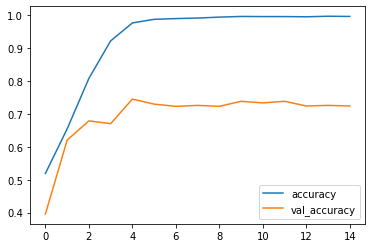

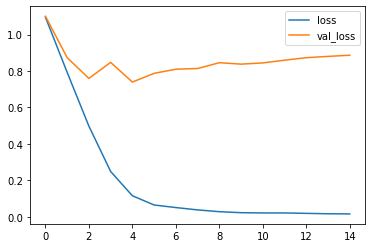

8174

In [117]:
es_callback = tf.keras.callbacks.EarlyStopping(patience=10, 
                                               verbose=1, 
                                               restore_best_weights=True)

history3 = model.fit(train_imgs_rand_2, 
                    train_df_rand_2, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS2, 
                    callbacks=[es_callback, get_lr_callback(BATCH_SIZE)], 
                    validation_data=(val_imgs, val_df))


pd.DataFrame(history3.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history3.history)[['loss', 'val_loss']].plot()
plt.show()

gc.collect()

### small net work

In [118]:
from tensorflow import keras
from tensorflow.keras import layers

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    x = inputs

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

image_size = (256, 256)
model = make_model(input_shape=image_size + (3,), num_classes=3)
opt = tf.keras.optimizers.SGD(momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [146]:
model.summary()

Model: "functional_27"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
rescaling_10 (Rescaling)        (None, 256, 256, 3)  0           input_19[0][0]                   
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 128, 128, 32) 896         rescaling_10[0][0]               
__________________________________________________________________________________________________
batch_normalization_96 (BatchNo (None, 128, 128, 32) 128         conv2d_57[0][0]                  
______________________________________________________________________________________

In [165]:
from tensorflow.python.keras.utils.vis_utils import plot_model
plot_model(model)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


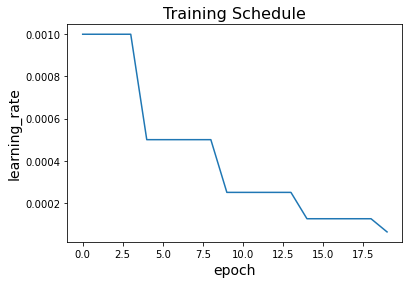

In [120]:
EPOCHS3 = 20
def get_lr_callback2(batch_size=32, plot=False):
    start_lr = 0.001
    def step_decay(epoch):
        drop = 0.5
        epochs_drop = 5.0
        lr = start_lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
        return lr
    
    lr_callback = tf.keras.callbacks.LearningRateScheduler(step_decay)
    if plot == True:
        rng = [i for i in range(EPOCHS3)]
        y = [step_decay(x) for x in rng]
        plt.plot(rng, y)
        plt.xlabel('epoch', size=14)
        plt.ylabel('learning_rate', size=14)
        plt.title('Training Schedule', size=16)
        plt.show()
        
    return lr_callback


get_lr_callback2(plot=True)

In [121]:
history4 = model.fit(train_imgs, 
                    train_df, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS3, 
                    callbacks=[es_callback, get_lr_callback2(BATCH_SIZE)], 
                    validation_data=(val_imgs, val_df))

Epoch 1/20
154/154 [==============================] - 548s 4s/step - loss: 1.0005 - accuracy: 0.5183 - val_loss: 1.1014 - val_accuracy: 0.3423
Epoch 2/20
154/154 [==============================] - 543s 4s/step - loss: 0.9205 - accuracy: 0.5774 - val_loss: 1.1199 - val_accuracy: 0.3423
Epoch 3/20
154/154 [==============================] - 544s 4s/step - loss: 0.8848 - accuracy: 0.5986 - val_loss: 1.1729 - val_accuracy: 0.3423
Epoch 4/20
154/154 [==============================] - 542s 4s/step - loss: 0.8810 - accuracy: 0.5970 - val_loss: 1.2251 - val_accuracy: 0.3423
Epoch 5/20
154/154 [==============================] - 543s 4s/step - loss: 0.8504 - accuracy: 0.6222 - val_loss: 1.0440 - val_accuracy: 0.4267
Epoch 6/20
154/154 [==============================] - 547s 4s/step - loss: 0.8409 - accuracy: 0.6263 - val_loss: 0.7983 - val_accuracy: 0.6616
Epoch 7/20
154/154 [==============================] - 543s 4s/step - loss: 0.8162 - accuracy: 0.6383 - val_loss: 2.3512 - val_accuracy: 0.3931

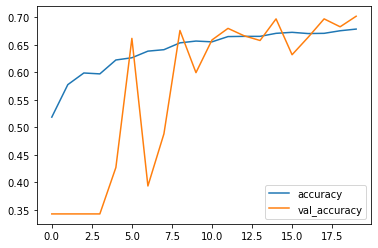

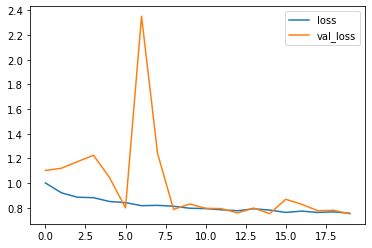

9923

In [122]:
pd.DataFrame(history4.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history4.history)[['loss', 'val_loss']].plot()
plt.show()

gc.collect()

In [140]:
s1 = pd.DataFrame(history.history['accuracy'], columns=['original'])
s2 = pd.DataFrame(history3.history['accuracy'], columns=['half-random'])
s3 = pd.DataFrame(history2.history['accuracy'], columns=['all-random'])
df_out = pd.concat([s1, s2, s3], axis=1)

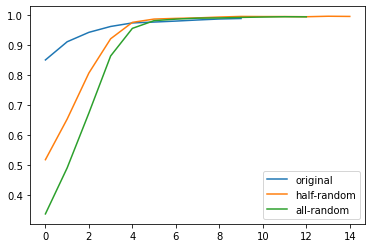

In [141]:
df_out.plot()

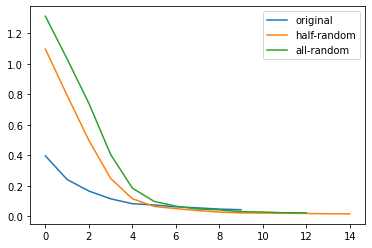

In [142]:
s1 = pd.DataFrame(history.history['loss'], columns=['original'])
s2 = pd.DataFrame(history3.history['loss'], columns=['half-random'])
s3 = pd.DataFrame(history2.history['loss'], columns=['all-random'])
df_out = pd.concat([s1, s2, s3], axis=1)
df_out.plot()

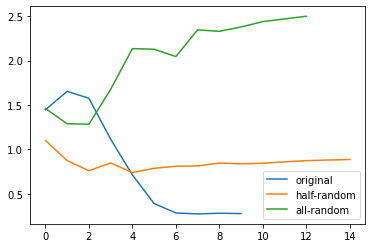

In [143]:
s1 = pd.DataFrame(history.history['val_loss'], columns=['original'])
s2 = pd.DataFrame(history3.history['val_loss'], columns=['half-random'])
s3 = pd.DataFrame(history2.history['val_loss'], columns=['all-random'])
df_out = pd.concat([s1, s2, s3], axis=1)
df_out.plot()

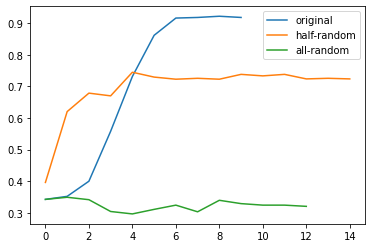

In [144]:
s1 = pd.DataFrame(history.history['val_accuracy'], columns=['original'])
s2 = pd.DataFrame(history3.history['val_accuracy'], columns=['half-random'])
s3 = pd.DataFrame(history2.history['val_accuracy'], columns=['all-random'])
df_out = pd.concat([s1, s2, s3], axis=1)
df_out.plot()

In [161]:
import pydot_ng

In [166]:
# Layer (type)                    Output Shape         Param #     Connected to                     
==================================================================================================
input (InputLayer)           [(None, 256, 256, 3)     0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)        (None, 256, 256, 3)      0           input[0][0]                   
__________________________________________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)     896         rescaling[0][0]               
__________________________________________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)     128         conv2d[0][0]                  
__________________________________________________________________________________________________
activation (Activation)      (None, 128, 128, 32)     0           batch_normalization[0][0]     
__________________________________________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 64)     18496       activation[0][0]              
__________________________________________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 64)     256         conv2d[0][0]                  
__________________________________________________________________________________________________
activation (Activation)      (None, 128, 128, 64)     0           batch_normalization[0][0]     
__________________________________________________________________________________________________
activation (Activation)      (None, 128, 128, 64)     0           activation[0][0]              
__________________________________________________________________________________________________
separable_conv2d (SeparableC (None, 128, 128, 128     8896        activation[0][0]              
__________________________________________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 128     512         separable_conv2d[0][0]        
__________________________________________________________________________________________________
activation (Activation)      (None, 128, 128, 128     0           batch_normalization[0][0]     
__________________________________________________________________________________________________
separable_conv2d (SeparableC (None, 128, 128, 128     17664       activation[0][0]              
__________________________________________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 128     512         separable_conv2d[0][0]        
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 128)      0           batch_normalization[0][0]     
__________________________________________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 128)      8320        activation[0][0]              
__________________________________________________________________________________________________
add (Add)                    (None, 64, 64, 128)      0           max_pooling2d[0][0]           
                                                                  conv2d[0][0]                  
__________________________________________________________________________________________________
separable_conv2d (SeparableC (None, 64, 64, 1024)     133248      add[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchN  (None, 64, 64, 1024)      4096        separable_conv2d[0][0]        
__________________________________________________________________________________________________
activation (Activation)      (None, 64, 64, 1024)      0           batch_normalization[0][0]    
__________________________________________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0           activation[0][0]              
__________________________________________________________________________________________________
dropout (Dropout)            (None, 1024)              0           global_average_pooling2d[0][0]
__________________________________________________________________________________________________
dense (Dense)                (None, 3)                 3075        dropout[0][0]                 
==================================================================================================
Total params: 196,099
Trainable params: 193,347
Non-trainable params: 2,752
__________________________________________________________________________________________________

SyntaxError: invalid syntax (<ipython-input-166-61fa35f88552>, line 2)